## Creation de la methode ROI

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import sys

In [8]:
def show(img):
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])

In [9]:
def maxSize(lst):
  size = []
  for arr in lst:
    x,y,z = arr.shape
    size.append(x)
  maxpos = size.index(max(size))
  return (lst[maxpos])

In [10]:
def getROI(input_path , output_path):
  # read image and convert it to gray 
  img_original = cv2.imread(input_path)
  h, w,_ = img_original.shape
  img0 = np.zeros((h+160,w,3), np.uint8)
  img0[80:-80,:] = img_original
  img = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

  plt.figure(figsize=(15,5))
  plt.subplot(131)
  show(img)

  # smoothing the image 
  blur = cv2.GaussianBlur(img, (5,5),0)
  plt.subplot(132)
  show(blur)

  # extract hand by gray scale threshold
  _, th = cv2.threshold(blur, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  plt.subplot(133)
  show(th)
  plt.tight_layout()
  plt.show()

  # use opencv moment to find out the centre of hand(x_C, Y_C)
  M = cv2.moments(th)
  h, w = img.shape
  x_c = M['m10'] // M['m00']
  y_c = M['m01'] // M['m00']
  
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  show(th)
  plt.plot(x_c , y_c, 'bx', markersize=10)  # !!!!!!!!!!!!!!!!!!!!!!!markers!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


  # set kernel and use erosion to find hand boundary
  kernel = np.array([[0, 1, 0],
                     [1, 1, 1],
                     [0, 1, 0]]).astype(np.uint8)
  erosion = cv2.erode(th, kernel, iterations=1)       # !!!!!!!!!!!!!!!!!!!!!!!Iterator!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  boundary = th - erosion

  # find the countours tree of the hand
  cnt, _ = cv2.findContours(boundary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  # find the longest counour
  cnt = maxSize(cnt)

  # drow the countour
  img_cnt = cv2.drawContours(img_c, [cnt], 0, (255,0,0), 2)
  plt.subplot(122)
  plt.plot(x_c, y_c, 'bx', markersize=10) # !!!!!!!!!!!!!!!!!!!!!!!markers!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  show(img_cnt)
  plt.tight_layout()
  plt.show()

  # find the distance betwen countor and center
  cnt = cnt.reshape(-1,2)

  left_id = np.argmin(cnt.sum(-1))

  cnt = np.concatenate([cnt[left_id:,:], cnt[:left_id,:]])

  dist_c = np.sqrt(np.square(cnt-[x_c, y_c]).sum(-1))
  f = np.fft.rfft(dist_c)

  # smoothing the dist graph
  cutoff = 15
  f_new = np.concatenate([f[:cutoff], 0*f[cutoff:]])
  dist_c_i = np.fft.irfft(f_new)
  plt.figure(figsize=(15,5))
  plt.grid()
  plt.plot(dist_c, label='Original ED function', color='r', linewidth=3, linestyle='--')
  plt.plot(dist_c_i, label='low frequency reconstruction', color='b', linestyle='-')
  plt.legend()
  plt.show()

  # find the derivate and the minimos(volley of hand)
  derivative = np.diff(dist_c_i)
  sign_change = np.diff(np.sign(derivative))/2
  plt.figure(figsize=(15,5))
  plt.plot(sign_change)
  plt.plot(derivative)
  plt.axhline(y=0, color='r')
  plt.grid()
  plt.show()

  minimas = cnt[np.where(sign_change>0)[0]]

  # v1, v2 are the volley points (middle, index) (ring, pinky)

  v1, v2 = minimas[-2], minimas[-4]
  plt.figure(figsize=(15,5))
  show(img)
  plt.plot(v1[0], v1[1], 'rx')
  plt.plot(v2[0], v2[1], 'bx')

  plt.subplot(132)
  theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
  print("the rotation of ROI is {:.02f}\u00b0".format(theta))

  # ==========================================================
  # sometimes may assign worng volley points
  if(theta > 33):
    v1, v2 = minimas[-1], minimas[-3]
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    show(img)
    plt.plot(v1[0], v1[1], 'rx')
    plt.plot(v2[0], v2[1], 'bx')
    plt.subplot(132)
    theta = np.arctan2((v2-v1)[1], (v2-v1)[0])*180/np.pi
    print("the rotation of ROI is {:.02f}\u00b0".format(theta))
    
  # ==========================================================

  # rotate the image to where v1 and v2 is horizontal
  R = cv2.getRotationMatrix2D(tuple(map(int, np.round(v2))), theta, 1)
  img_r = cv2.warpAffine(img0, R, (w,h))
  v1 = (R[:,:2] @ v1 + R[:,-1]).astype(int)
  v2 = (R[:,:2] @ v2 + R[:,-1]).astype(int)
  plt.plot(v1[0], v1[1], 'rx')
  plt.plot(v2[0], v2[1], 'bx')
  show(img_r)

  # location of ROI
  ux = v1[0]
  uy = v1[1] + (v2-v1)[0]//3
  lx = v2[0]
  ly = v2[1] + 4*(v2-v1)[0]//3
  # img_c = cv2.cvtColor(img_r, cv2.COLOR_GRAY2BGR)
  # cv2.rectangle(img_r, (lx,ly),(ux,uy),(0,255,0),2)
  # plt.subplot(133)
  # show(img_r)

  plt.tight_layout()
  plt.show()

  roi = img_r[uy:ly,ux:lx]
  plt.figure(figsize=(5,5))
  show(roi)
  cv2.imwrite(output_path,roi)


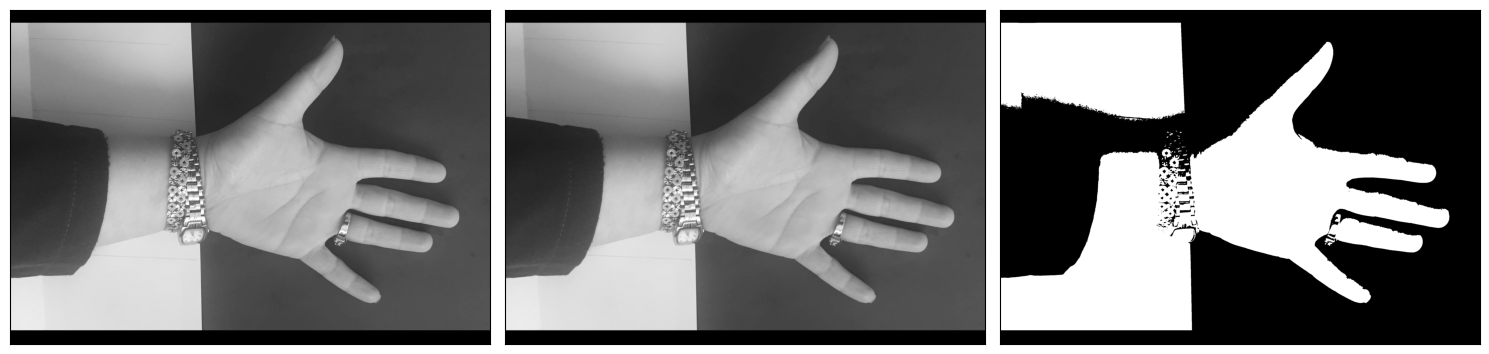

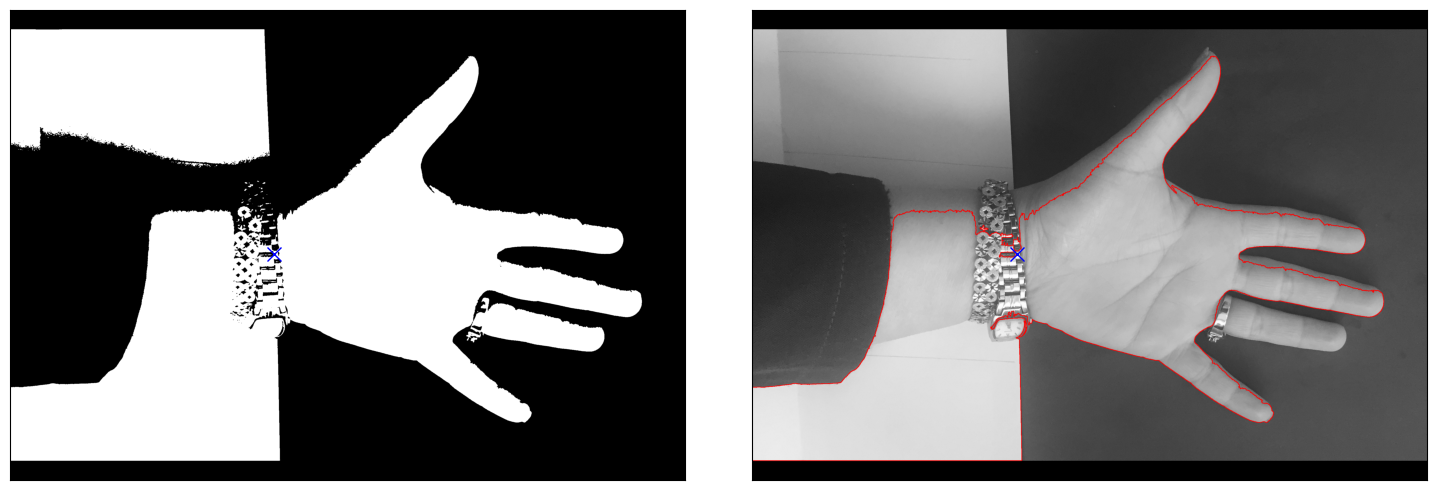

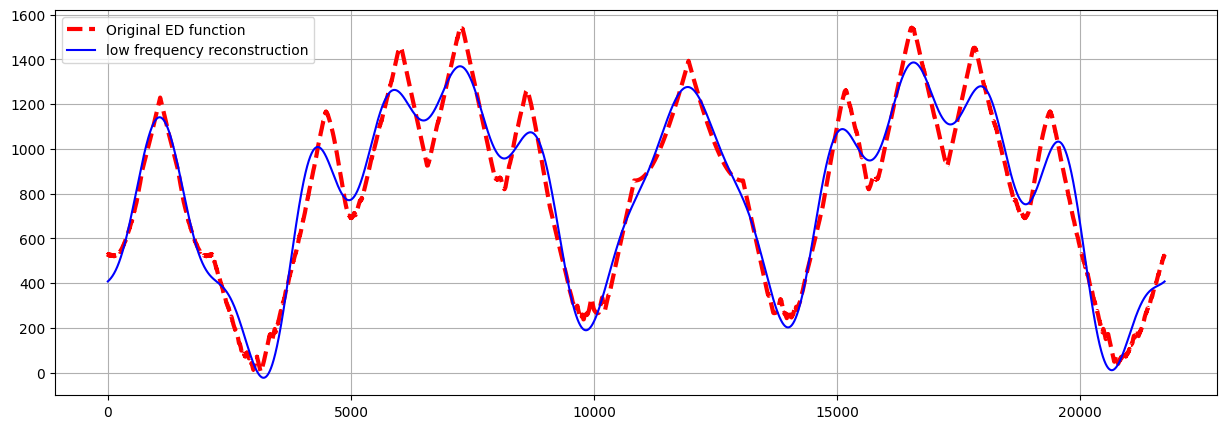

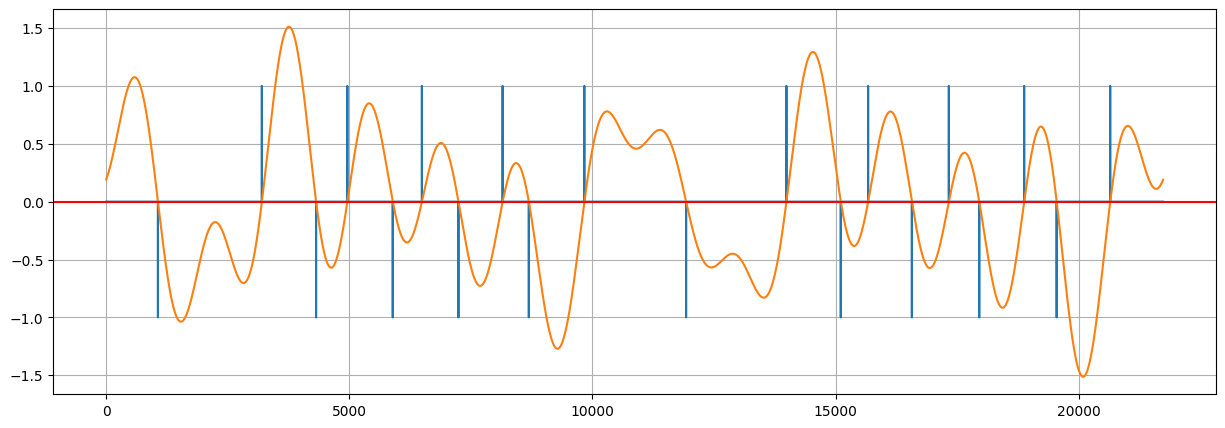

<ipython-input-35-1715f9781a00>:101: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)


the rotation of ROI is 77.57°
the rotation of ROI is 4.19°


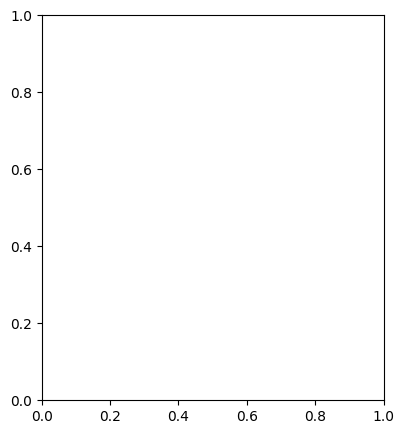

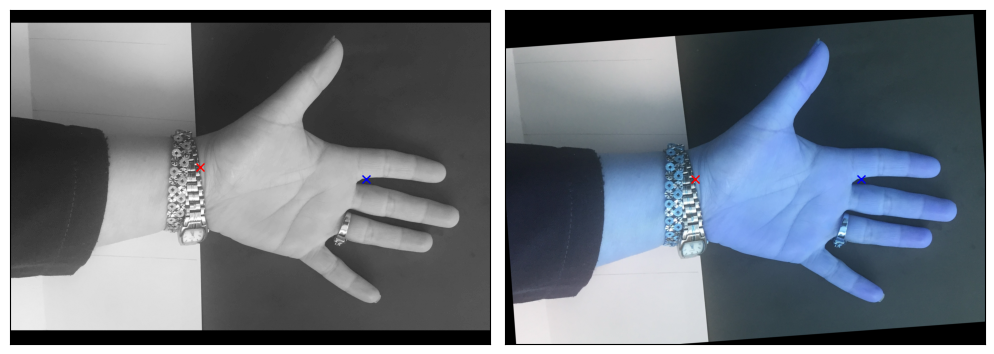

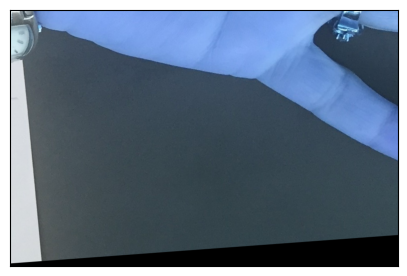

In [ ]:
img = '/content/test2.JPG'
result = '/content/result.JPG'
getROI(img,result)

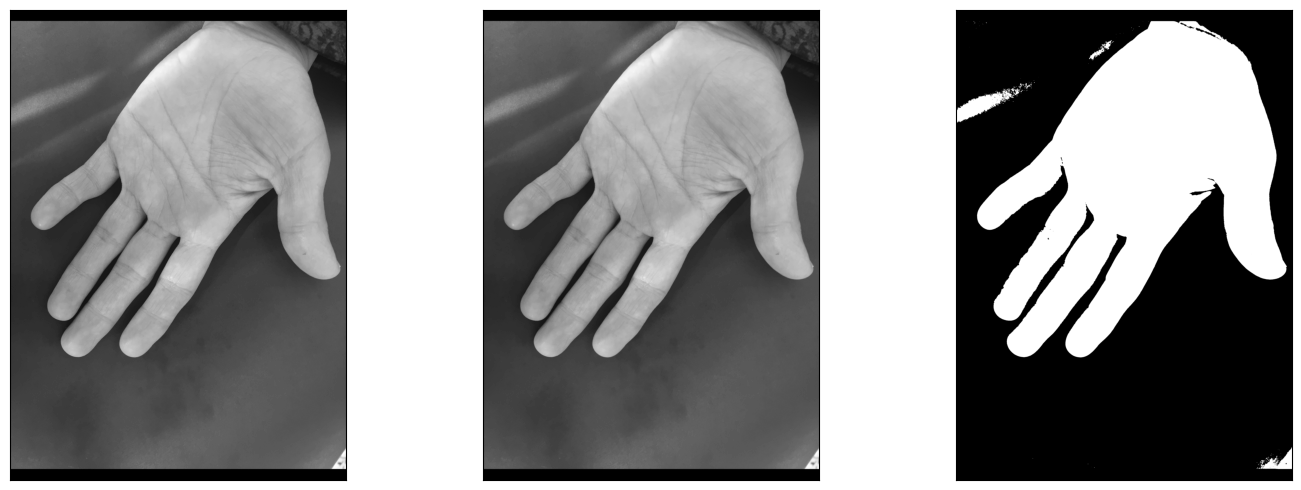

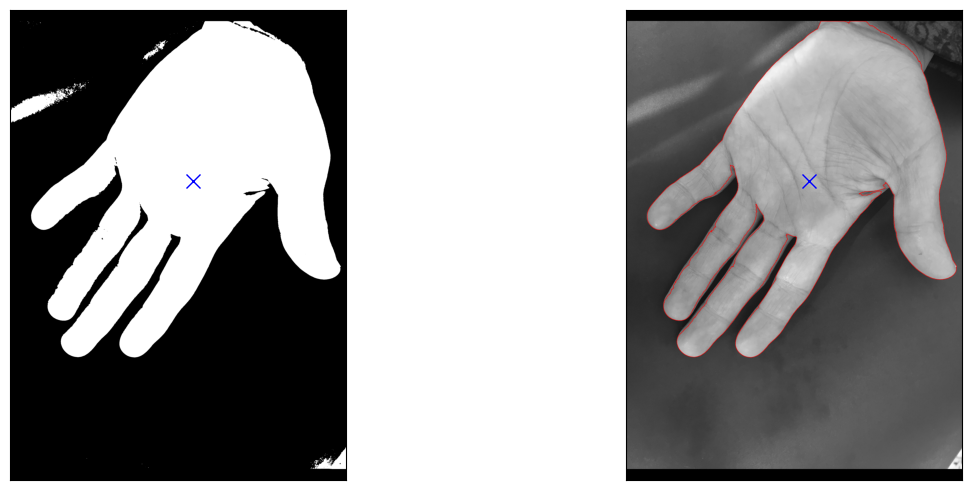

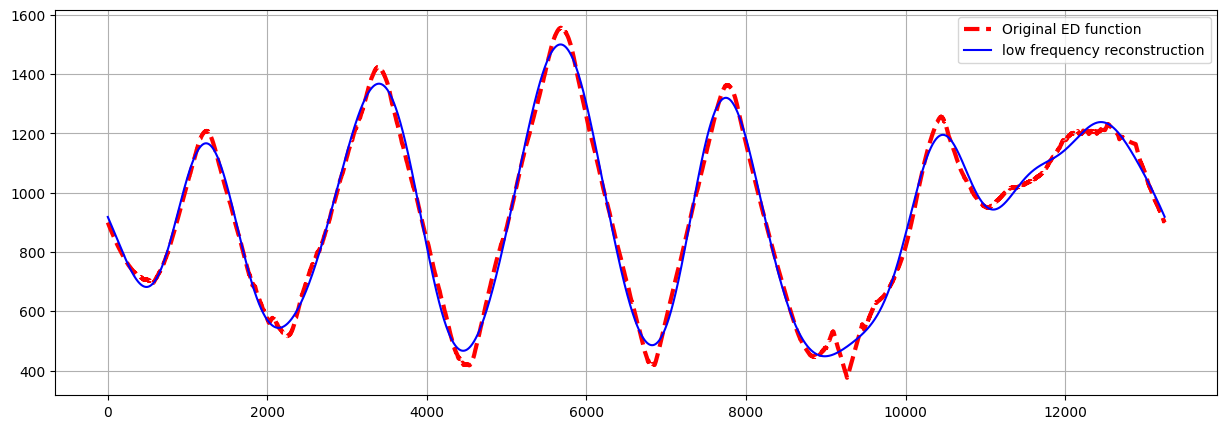

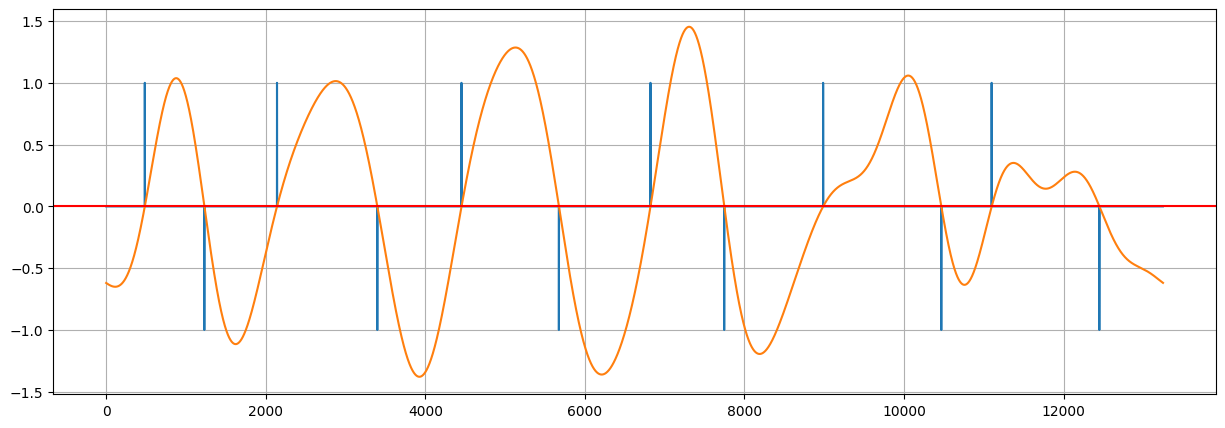

<ipython-input-35-1715f9781a00>:101: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)


the rotation of ROI is 179.86°
the rotation of ROI is 160.73°


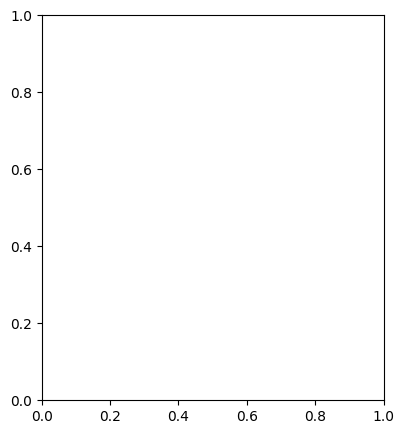

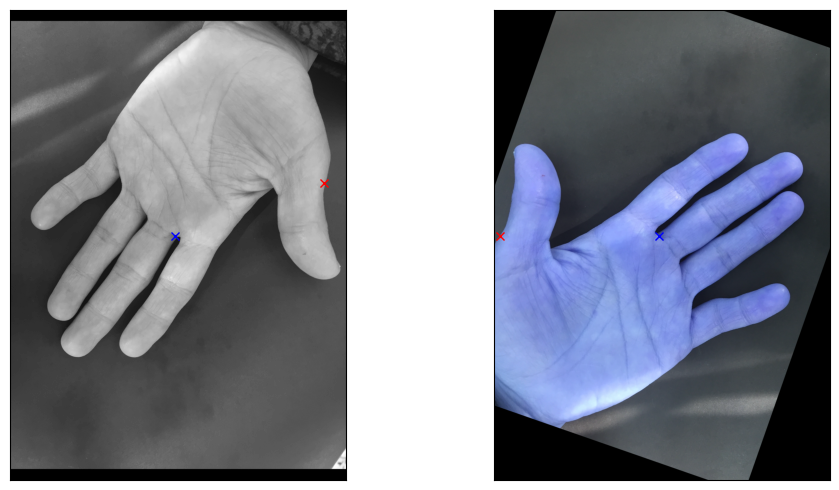

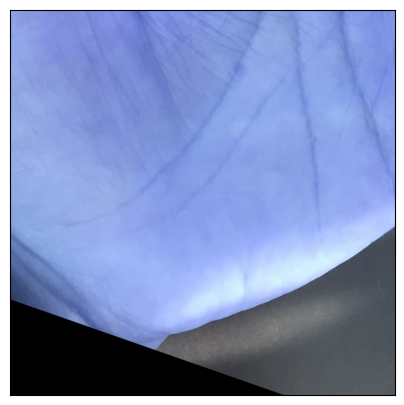

In [ ]:
img = '/content/test3.JPG'
result = '/content/result3.JPG'
getROI(img,result)

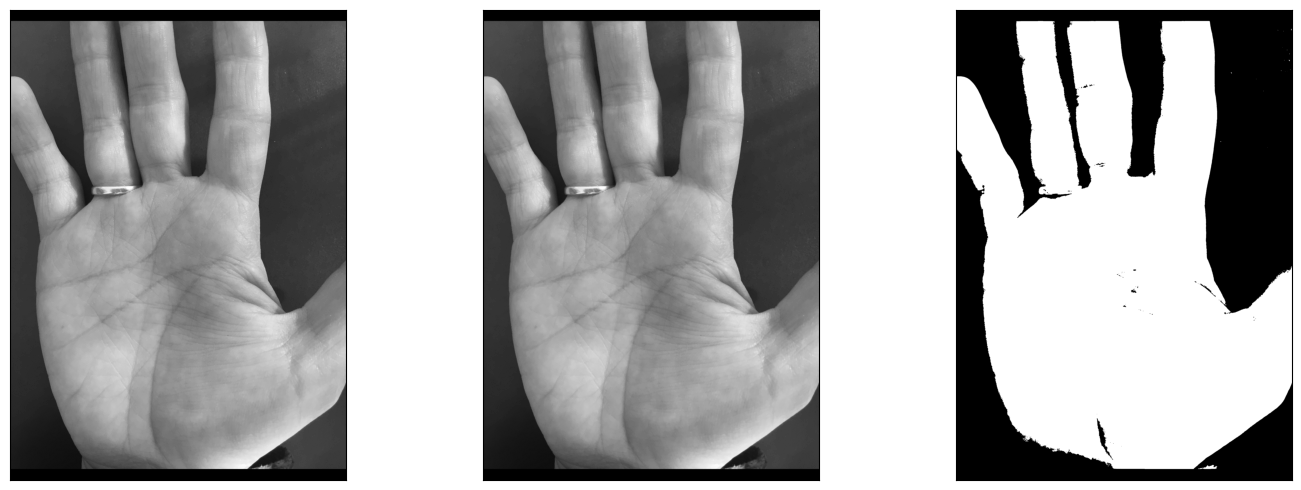

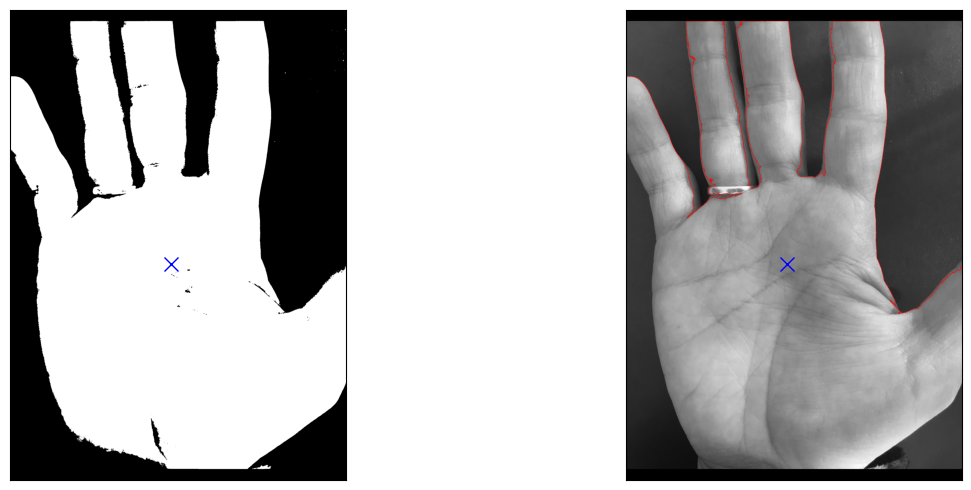

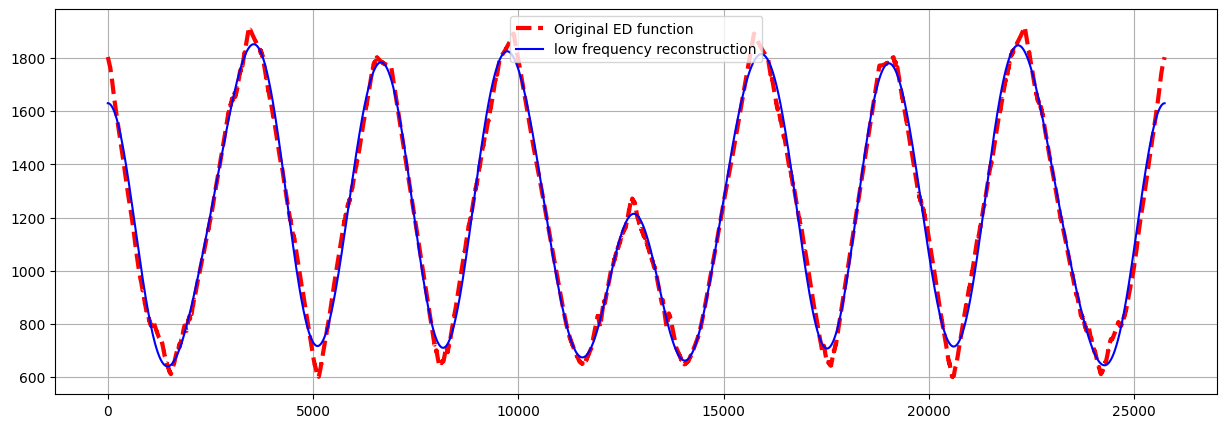

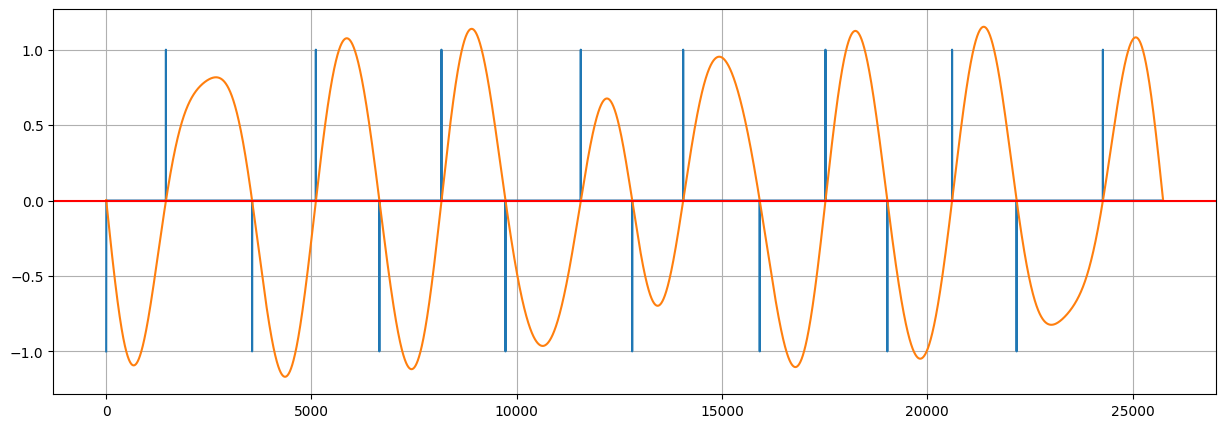

<ipython-input-40-450ed22b325e>:101: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)


the rotation of ROI is 27.47°


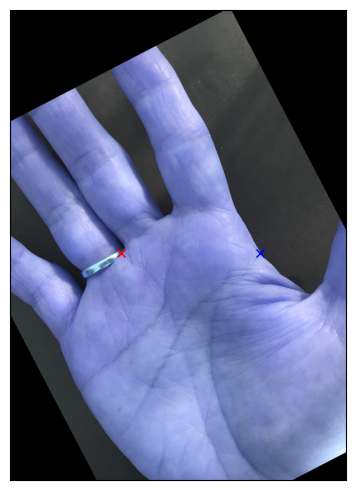

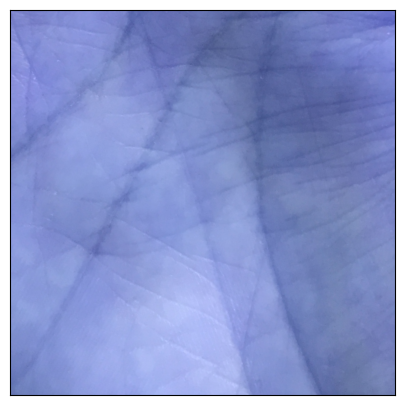

In [ ]:
img = '/content/test4.JPG'
result = '/content/result4.JPG'
getROI(img,result)

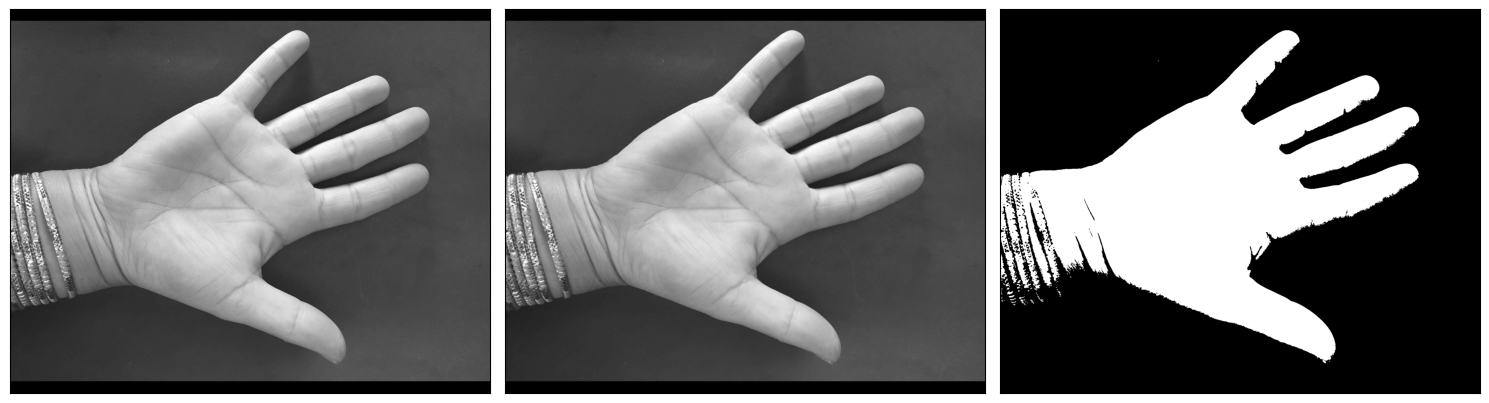

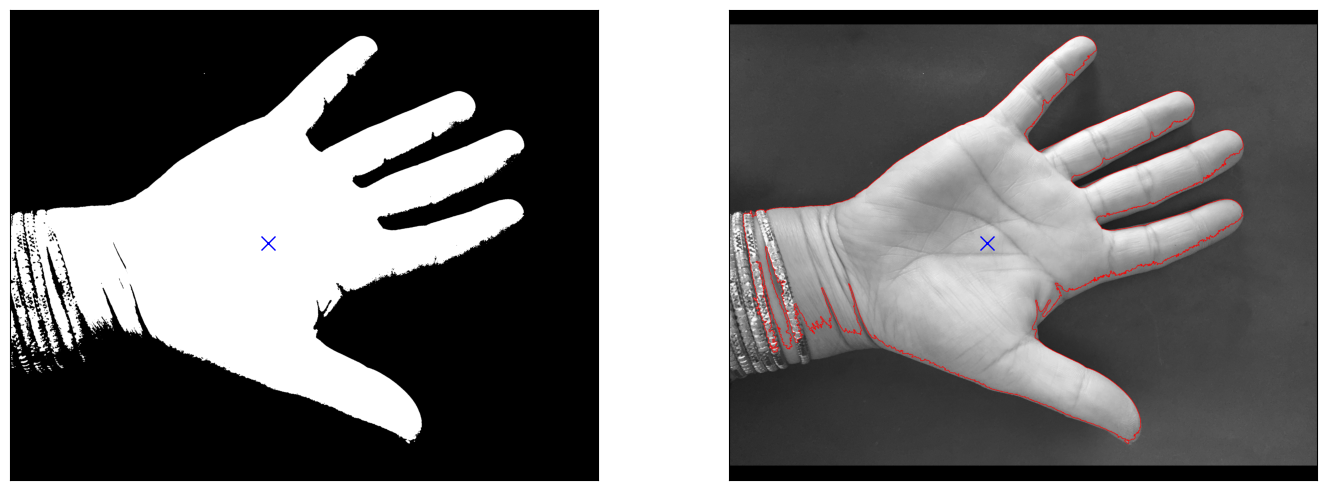

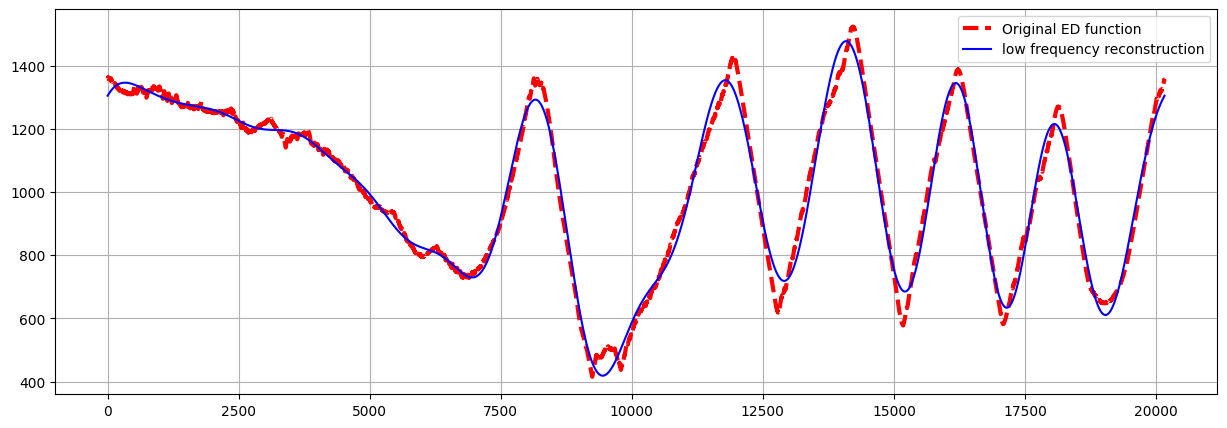

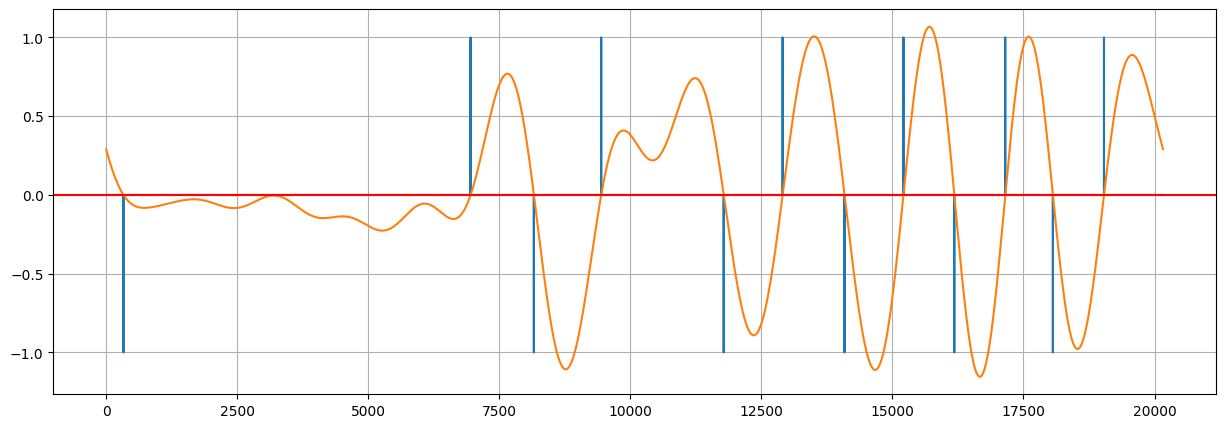

<ipython-input-40-450ed22b325e>:101: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(132)


the rotation of ROI is 42.31°
the rotation of ROI is 13.43°


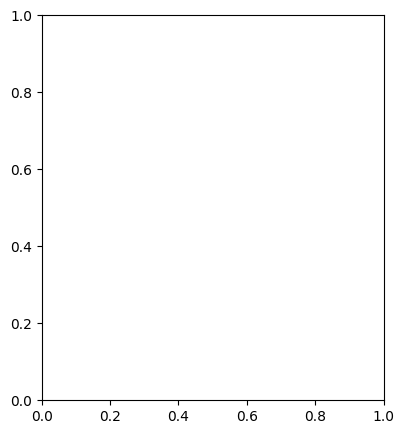

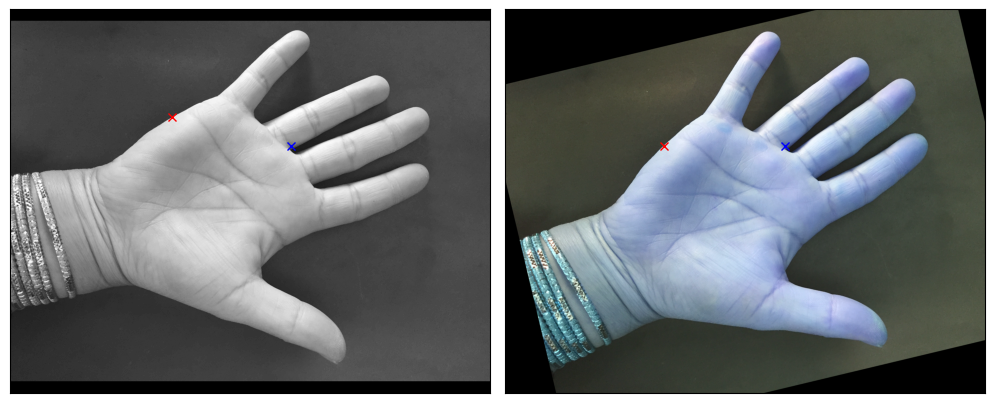

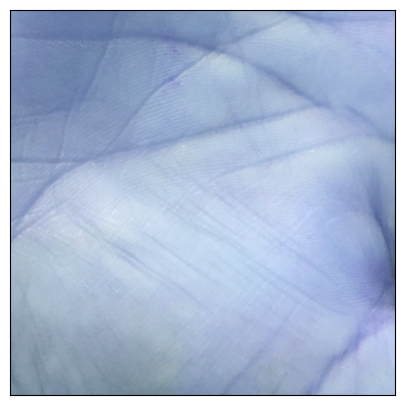

In [ ]:
img = '/content/test.JPG'
result = '/content/result.JPG'
getROI(img,result)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/mydrive


In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


database_path = "/content/drive/MyDrive/Palmprint_db/train"
roi_path = "/content/drive/MyDrive/roi"

# for image_name in os.listdir(database_path):
#     image_path = os.path.join(database_path, image_name)
#     # Ajouter une vérification pour éviter de traiter des images vides ou corrompues
#     if os.path.getsize(image_path) > 0:
#       roi_name = os.path.splitext(image_name)[0] + "_roi.png"
#       roi_path_person = os.path.join(roi_path, image_name)
#       if not os.path.exists(roi_path_person):
#           os.makedirs(roi_path_person)
#       roi_path_person_image = os.path.join(roi_path_person, roi_name)
#       getROI(image_path, roi_path_person_image)

import cv2
import os

def process_dataset(database_path, roi_path):
    for person_folder in os.listdir(database_path):
      try:
        
        person_folder_path = os.path.join(database_path, person_folder)
        roi_path_person = os.path.join(roi_path, person_folder)
        if not os.path.exists(roi_path_person):
            os.makedirs(roi_path_person)
        for image_name in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, image_name)
            if os.path.getsize(image_path) > 0:
                roi_name = person_folder + "_" + image_name
                roi_path_person_image = os.path.join(roi_path_person, roi_name)
                getROI(image_path, roi_path_person_image)





In [26]:
import numpy as np
import os
import cv2

def process_dataset(database_path, roi_path):
    for filename in os.listdir(database_path):
        try:
            img = cv2.imread(os.path.join(database_path, filename))
            roi = cv2.imread(os.path.join(roi_path, filename), cv2.IMREAD_GRAYSCALE)
            # ... do some processing ...
        except Exception as e:
            print(f"Error processing image: {os.path.join(database_path, filename)}")
            print(f"Error message: {str(e)}")

# Example usage:
database_path = "/path/to/database"
roi_path = "/path/to/roi"
process_dataset(database_path, roi_path)

Output hidden; open in https://colab.research.google.com to view.